In [1]:
import pandas as pd
import numpy as np
import os
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns

ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, 'data/')
IMGS_DIR = os.path.join(ROOT_DIR, 'imgs/')

/home/cakiroglu/virtualenv_/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/cakiroglu/virtualenv_/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Useful function for plotting

In [2]:
def plot_corr(first_column, second_column, first_label, second_label, figsize=(15,6), directory=False):
    fig, ax1 = plt.subplots(figsize=figsize)
    
    ax1.set_ylabel(first_label, color='b')
    ax1.tick_params('y', colors='b', labelsize=14)
    first_column.plot(ax=ax1, color='b')

    ax2 = ax1.twinx()
    
    ax2.set_ylabel(second_label, color='g')
    ax2.tick_params('y', colors='g', labelsize=14)
    
    title = first_label + " Change Over " + second_label
    second_column.plot(ax=ax2, color='g', linestyle='--', title=title)
    
    if directory is not False:
        plt.savefig(directory)
    fig.tight_layout()
    plt.show()
    
def save_table(df, label, head=True, IMGS_DIR=os.path.join(os.getcwd(), 'imgs/')):
    if head:
        df = df.head()
    df.to_html(IMGS_DIR + '{}.html'.format(label))

    subprocess.call(
        'wkhtmltoimage -f png --width 0 {0}{1}.html {0}{1}.png'.format(IMGS_DIR, label), shell=True)
    return df

In [3]:
features_df = pd.read_csv(DATA_DIR + 'features.csv')
stores_df = pd.read_csv(DATA_DIR + 'stores.csv')
train_df = pd.read_csv(DATA_DIR + 'train.csv')

### Displaying piechart of type of stores

In [4]:
temp_types = stores_df['Type'].value_counts().index
temp_counts = stores_df['Type'].value_counts()
temp_labels = [str(i) + ': '+str(j) for i,j in zip(temp_types, temp_counts)]

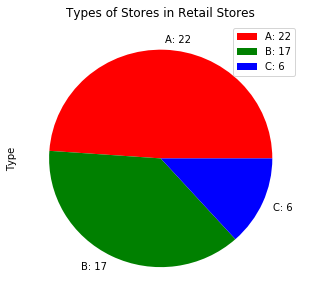

In [5]:
plt.figure()
stores_df['Type'].value_counts().plot.pie(figsize=(5,5), legend=True, colors=['r','g','b'], labels=temp_labels, title='Types of Stores in Retail Stores');
plt.savefig(IMGS_DIR + 'stores_pie.png')

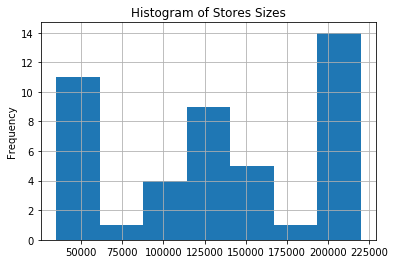

In [6]:
plt.figure()
stores_df.Size.plot.hist(bins=7, title='Histogram of Stores Sizes', grid=True);
plt.savefig(IMGS_DIR + 'stores_hist.png')

In [7]:
stores_dic = {}
for typ in stores_df.Type.unique():
    where_type = stores_df.Type == typ
    mean = stores_df.Size[where_type].mean()
    std = stores_df.Size[where_type].std()
    median = stores_df.Size[where_type].median()
    count = len(stores_df.Size[where_type])
    stores_dic[typ] = (count, mean, median, std)

stats_stores = pd.DataFrame(stores_dic).set_index(pd.Series(['count', 'mean', 'median', 'std'])).round(2)

In [8]:
save_table(stats_stores, 'stores_stats', head=False)

,A,B,C
count,22.00,17.00,6.00
mean,177247.73,101190.71,40541.67
median,202406.00,114533.00,39910.00
std,49392.62,32371.14,1304.15


In [9]:
type_a = stores_df.Type=='A'
type_b = stores_df.Type=='B'
type_c = stores_df.Type=='C'

type_a*=1
type_b*=2
type_c*=3

encoded_colors = type_a + type_b + type_c
colors = encoded_colors.map({1:'r', 2:'g', 3:'b'})

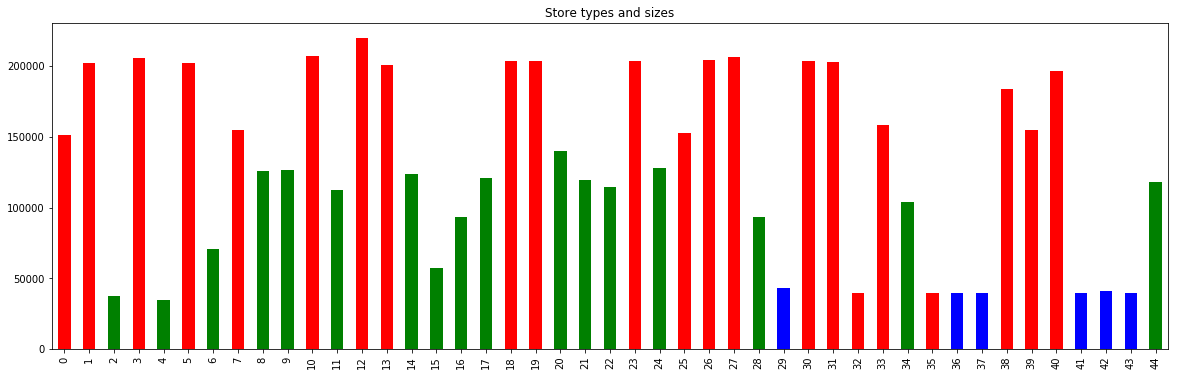

In [10]:
plt.figure()
stores_df.Size.plot.bar(color=colors, title='Store types and sizes', figsize=(20,6));
plt.savefig(IMGS_DIR + 'stores_bar.png')

### Creating final dataframe 

In [11]:
featured_train_df = pd.merge(train_df, features_df, on=['Store', 'Date', 'IsHoliday'])
featured_train_df.head()

final_df = pd.merge(featured_train_df, stores_df, on=['Store'])
final_df.Temperature = ((final_df.Temperature-32)*5/9).round(2)
final_df['Date'] = pd.to_datetime(final_df['Date'], format="%Y-%m-%d")
final_df['IsHoliday'] = final_df['IsHoliday']*1

types = final_df.Type.unique()
encoded_type = {}
for ind, typ in enumerate(types):
    encoded_type[typ] = ind
    
final_df['Type'] = final_df['Type'].map(encoded_type)
final_df = final_df.set_index('Date')

### Extracting holiday markdowns

In [12]:
isholiday_ind = final_df['IsHoliday'] == 1

christmas = np.logical_and(final_df.index.month == 12, isholiday_ind)
thanksgiving = np.logical_and(final_df.index.month == 11, isholiday_ind)
labor = np.logical_and(final_df.index.month == 9, isholiday_ind)
superbowl = np.logical_and(final_df.index.month == 2, isholiday_ind)

In [13]:
markdown_df = pd.DataFrame({'m1_christ':christmas, 'm2_thanks':thanksgiving, 'm3_labor':labor, 'm4_super':superbowl},dtype=int)
markdown_df = markdown_df.set_index(final_df.index)

week_df  = pd.DataFrame({'Week':final_df.index.week})
week_df = week_df.set_index(final_df.index)

final_df = pd.concat([final_df, markdown_df, week_df], axis=1)
final_df = final_df.drop(columns='IsHoliday')

In [14]:
save_table(final_df, 'final_df', head=True)

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,m1_christ,m2_thanks,m3_labor,m4_super,Week
Date,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,5.73,2.572,211.096358,8.106,0,151315,0,0,0,0,5
2010-02-05,1,2,50605.27,5.73,2.572,211.096358,8.106,0,151315,0,0,0,0,5
2010-02-05,1,3,13740.12,5.73,2.572,211.096358,8.106,0,151315,0,0,0,0,5
2010-02-05,1,4,39954.04,5.73,2.572,211.096358,8.106,0,151315,0,0,0,0,5
2010-02-05,1,5,32229.38,5.73,2.572,211.096358,8.106,0,151315,0,0,0,0,5


In [15]:
save_table(final_df.describe(), 'final_df_stats', head=False)

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,m1_christ,m2_thanks,m3_labor,m4_super,Week
count,294132.000000,294132.000000,294132.000000,294132.000000,294132.000000,294132.000000,294132.000000,294132.000000,294132.000000,294132.000000,294132.000000,294132.000000,294132.000000,294132.000000
mean,22.180178,44.184135,16105.306895,14.949479,3.209664,169.529527,8.232486,0.588260,136889.595597,0.020215,0.020260,0.020042,0.020039,27.493085
std,12.780170,30.430023,22961.301005,10.518941,0.439060,38.464447,1.865189,0.665224,60917.875957,0.140737,0.140887,0.140144,0.140133,14.527257
min,1.000000,1.000000,-4988.940000,-18.920000,2.472000,126.064000,4.420000,0.000000,34875.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,11.000000,18.000000,2146.025000,7.370000,2.808000,131.901968,7.287000,0.000000,93638.000000,0.000000,0.000000,0.000000,0.000000,15.000000
50%,22.000000,37.000000,7727.310000,15.790000,3.129000,182.077986,8.058000,0.000000,140167.000000,0.000000,0.000000,0.000000,0.000000,28.000000
75%,33.000000,72.000000,20356.665000,22.970000,3.595000,211.096358,8.684000,1.000000,202505.000000,0.000000,0.000000,0.000000,0.000000,40.000000
max,45.000000,99.000000,693099.360000,37.860000,4.211000,223.249677,14.313000,2.000000,219622.000000,1.000000,1.000000,1.000000,1.000000,52.000000


In [16]:
save_table(average_df, 'average_df', head=True)

NameError: name 'average_df' is not defined

In [ ]:
if True:
    corr = final_df.corr()
    corr1 = corr>0.25
    corr2 = corr<-0.25
    corr = corr1*1-corr2*1
    plt.figure(figsize=(8,6))
    plt.title('(Thresholded) Correlation Matrix of Features')
    sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values);
#     plt.savefig(IMGS_DIR + 'th_corr_matrix.png')

In [ ]:
if True:
    sample_store = np.logical_and(final_df.Store == 1, final_df.Dept == 1)
    plot_corr(final_df.Weekly_Sales[sample_store], final_df.Temperature[sample_store], 'Weekly_Sales', 'Temperature', figsize=(15,4), directory=IMGS_DIR + 'sample_temp.png')
    plot_corr(final_df.Weekly_Sales[sample_store], final_df.CPI[sample_store], 'Weekly_Sales', 'CPI', figsize=(15,4), directory=IMGS_DIR + 'sample_CPI.png')
    plot_corr(final_df.Weekly_Sales[sample_store], final_df.Fuel_Price[sample_store], 'Weekly_Sales', 'Fuel_Price', figsize=(15,4), directory=IMGS_DIR + 'sample_fuel.png')
    plot_corr(final_df.Weekly_Sales[sample_store], final_df.Unemployment[sample_store], 'Weekly_Sales', 'Unemployment', figsize=(15,4), directory=IMGS_DIR + 'sample_unemp.png')
    
    plot_corr(final_df.Weekly_Sales[sample_store], final_df.m1_christ[sample_store], 'Weekly_Sales', 'Christmas', figsize=(15,4), directory=IMGS_DIR + 'sample_christ.png')
    plot_corr(final_df.Weekly_Sales[sample_store], final_df.m2_thanks[sample_store], 'Weekly_Sales', 'Thanksgiving', figsize=(15,4), directory=IMGS_DIR + 'sample_thanks.png')
    plot_corr(final_df.Weekly_Sales[sample_store], final_df.m3_labor[sample_store], 'Weekly_Sales', 'Labor Day', figsize=(15,4), directory=IMGS_DIR + 'sample_labor.png')
    plot_corr(final_df.Weekly_Sales[sample_store], final_df.m4_super[sample_store], 'Weekly_Sales', 'Super Bowl', figsize=(15,4), directory=IMGS_DIR + 'sample_super.png')

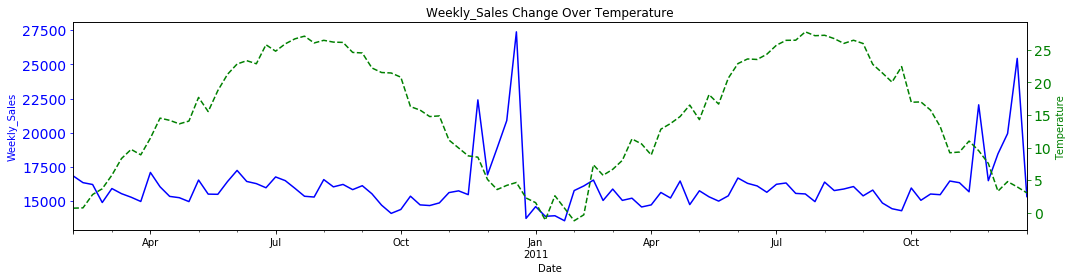

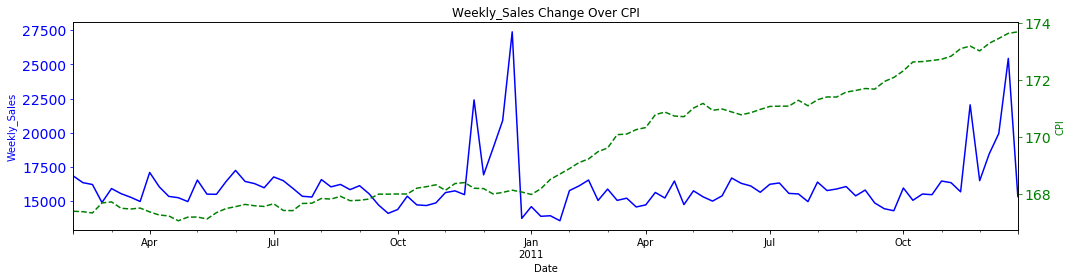

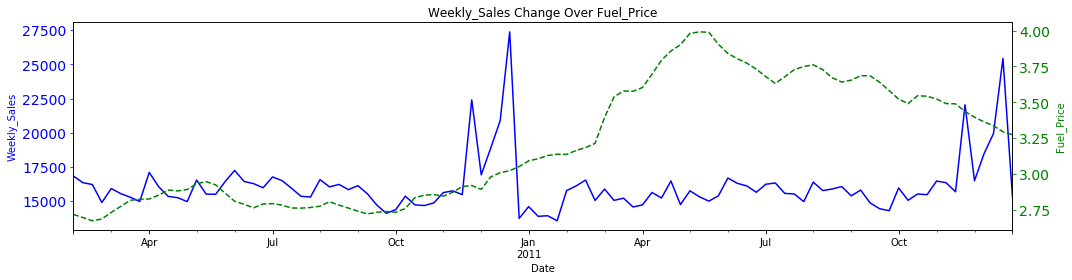

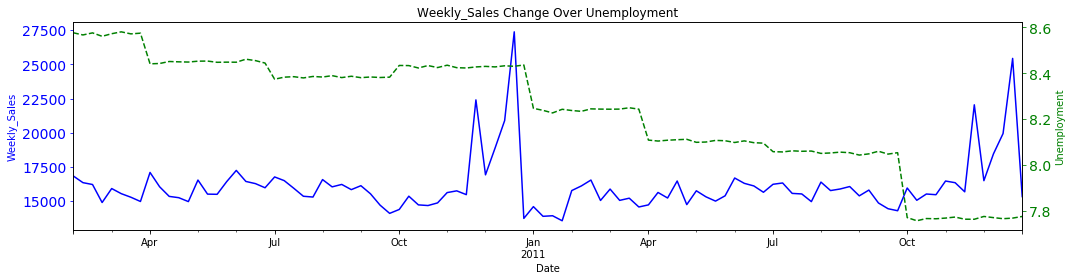

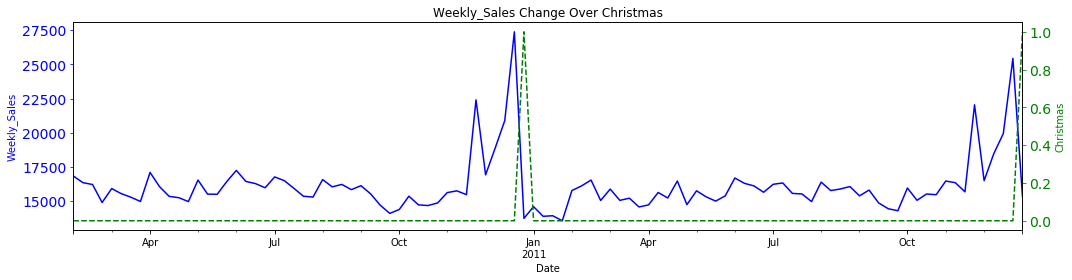

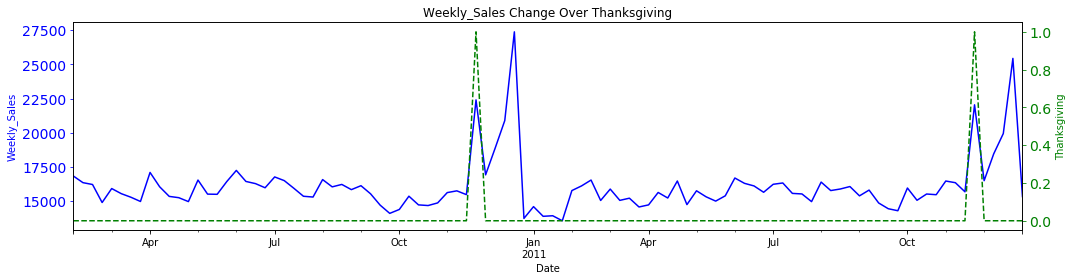

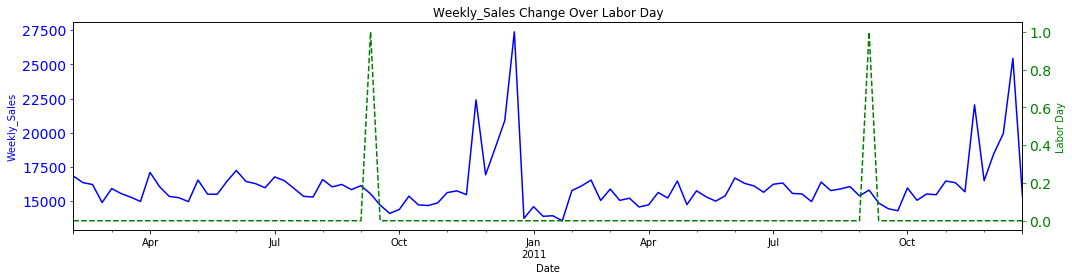

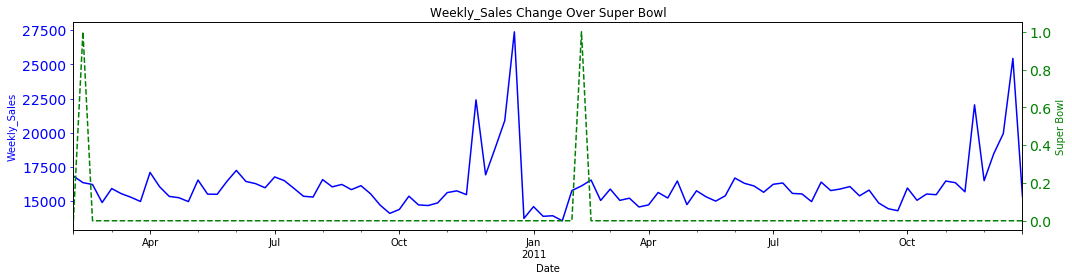

In [17]:
if True:
    average_df = final_df.groupby(final_df.index).mean()

    plot_corr(average_df.Weekly_Sales, average_df.Temperature, 'Weekly_Sales', 'Temperature', figsize=(15,4), directory=IMGS_DIR + 'average_temp.png')
    plot_corr(average_df.Weekly_Sales, average_df.CPI, 'Weekly_Sales', 'CPI', figsize=(15,4), directory=IMGS_DIR + 'average_CPI.png')
    plot_corr(average_df.Weekly_Sales, average_df.Fuel_Price, 'Weekly_Sales', 'Fuel_Price', figsize=(15,4), directory=IMGS_DIR + 'average_fuel.png')
    plot_corr(average_df.Weekly_Sales, average_df.Unemployment, 'Weekly_Sales', 'Unemployment', figsize=(15,4), directory=IMGS_DIR + 'average_unemp.png')
    plot_corr(average_df.Weekly_Sales, average_df.m1_christ, 'Weekly_Sales', 'Christmas', figsize=(15,4), directory=IMGS_DIR + 'average_christ.png')
    plot_corr(average_df.Weekly_Sales, average_df.m2_thanks, 'Weekly_Sales', 'Thanksgiving', figsize=(15,4), directory=IMGS_DIR + 'average_thanks.png')
    plot_corr(average_df.Weekly_Sales, average_df.m3_labor, 'Weekly_Sales', 'Labor Day', figsize=(15,4), directory=IMGS_DIR + 'average_labor.png')
    plot_corr(average_df.Weekly_Sales, average_df.m4_super, 'Weekly_Sales', 'Super Bowl', figsize=(15,4), directory=IMGS_DIR + 'average_super.png')

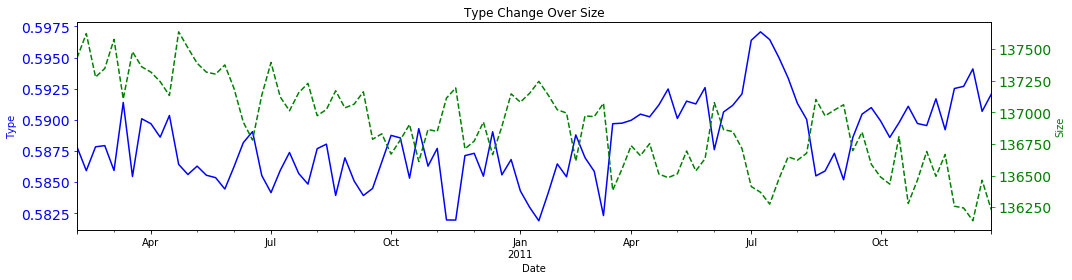

In [18]:
average_df = final_df.groupby(final_df.index).mean()
direc = IMGS_DIR + 'average_sizevstype.png'
plot_corr(average_df.Type, average_df.Size, 'Type', 'Size', figsize=(15,4), directory=direc)

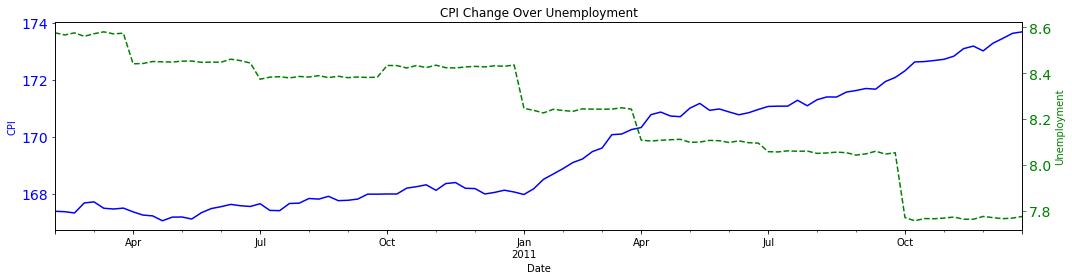

In [19]:
direc = IMGS_DIR + 'average_CPIvsunemp.png'
plot_corr(average_df.CPI, average_df.Unemployment, 'CPI', 'Unemployment', figsize=(15,4), directory=direc)